# unknown point sampling

## IDW point selection

- 각 포인트의 1789m 거리 내에 1m 간격의 포인트 생성
- 생성된 포인트에 대해 neighbors idw
- neighbors가 가장 작은 값 순서대로 선택

In [1]:
import pandas as pd
import utils.augmentation as aug
import utils.plot as plot
from tqdm import tqdm
from sklearn.neighbors import KDTree

In [2]:
df = pd.read_csv('data/241202_Rockhead_Seoul_train(before_aumentation).csv')

df_center = df[df['neighbors'] < 200]
df_center = df_center[df_center['neighbors'] > 10]

df_center['num_points'] = 10

points = df_center[['x','y']].to_numpy()
num_points = df_center[['num_points']].to_numpy()

radius = 1789

In [3]:
new_point = pd.DataFrame(columns=['x', 'y', 'neighbors'])

In [4]:
location = df.loc[:,['x','y']].to_numpy()
values = df['neighbors'].to_numpy()
tree = KDTree(location, leaf_size=15000)
neighbors = tree.query_radius(points, r=radius)

for i in tqdm(range(0, len(points))):
    grid_points = aug.generate_grid_points(points[i][0], points[i][1], radius, 100)
    tree = KDTree(location[neighbors[i]], leaf_size=15000)
    dists, indices = tree.query(grid_points, k=len(neighbors[i]), return_distance=True)
    interpolated_values = aug.idw_interpolation(dists, indices, values[neighbors[i]], 1)
    
    selected_points, selected_values = aug.select_points_by_value(grid_points, interpolated_values, num_points[i][0])
    
    new_rows = pd.DataFrame({'x': selected_points[:, 0], 'y': selected_points[:, 1], 'neighbors': selected_values})
    new_point = pd.concat([new_point, new_rows], ignore_index=True)

new_point.to_csv('data/241202_Rockhead_Seoul_unknown_point.csv')

  0%|          | 0/3095 [00:00<?, ?it/s]C:\Users\mijin\AppData\Local\Temp\ipykernel_38336\137383283.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_point = pd.concat([new_point, new_rows], ignore_index=True)
100%|██████████| 3095/3095 [01:27<00:00, 35.49it/s]


In [5]:
new_point['unknown'] = 1

df1 = df[['x', 'y', 'neighbors']]
df1['unknown'] = 0

result = pd.concat([df1, new_point], ignore_index=True)

print(new_point.info())
print(result.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30950 entries, 0 to 30949
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   x          30950 non-null  float64
 1   y          30950 non-null  float64
 2   neighbors  30950 non-null  float64
 3   unknown    30950 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 967.3 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43723 entries, 0 to 43722
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   x          43723 non-null  float64
 1   y          43723 non-null  float64
 2   neighbors  43723 non-null  float64
 3   unknown    43723 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 1.3 MB
None


C:\Users\mijin\AppData\Local\Temp\ipykernel_38336\933868881.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['unknown'] = 0


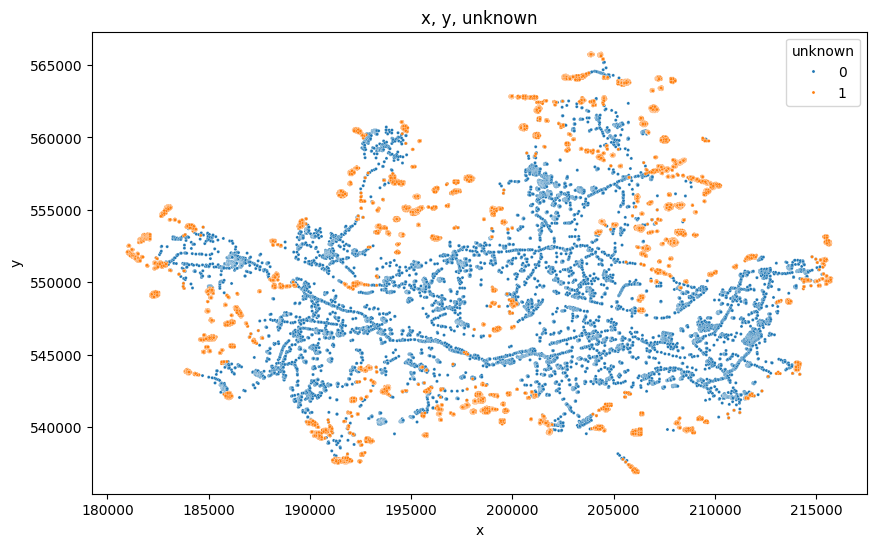

In [6]:
plot.scatter_relation(result, 'x', 'y', 5, 'x, y, unknown','unknown')